In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Fri Aug 20 12:53:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 12.8 MB/s 
     |████████████████████████████████| 636 kB 38.4 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 3.3 MB 30.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install pytorch-lightning

     |████████████████████████████████| 916 kB 10.6 MB/s 
     |████████████████████████████████| 118 kB 40.4 MB/s 
     |████████████████████████████████| 829 kB 37.7 MB/s 
     |████████████████████████████████| 272 kB 47.7 MB/s 
     |████████████████████████████████| 1.3 MB 39.7 MB/s 
     |████████████████████████████████| 294 kB 48.1 MB/s 
     |████████████████████████████████| 142 kB 51.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=701ee6fac0fe7b7339a21cde1c05a7fef9395a7ab0c48970108a9edc780b1bd9
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [6]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [8]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/train_set.csv')
train_df = train_df.dropna()
train_df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,INTRODUCTION COVID-19 infection caused new str...,0,0,0,0,1,0,0
1,BACKGROUND novel antiviral agent remdesivir RD...,0,0,0,0,0,0,1
2,hypothesis address biological/immunological pa...,0,0,0,1,0,0,1
3,BACKGROUND Assessing effectiveness safety acup...,0,0,0,0,0,0,1
4,One primary function control monitor internati...,0,0,0,0,1,0,0


In [9]:
  # train_df, val_df = train_test_split(df, test_size=0.1)
# train_df.shape, val_df.shape

In [10]:
LABEL_COLUMNS = train_df.columns.tolist()[1:]

In [11]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [12]:
train_df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting      763
Transmission             1202
Case Report              2275
Mechanism                4941
Diagnosis                6967
Treatment                9801
Prevention              12459
dtype: int64

In [13]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

NameError: ignored

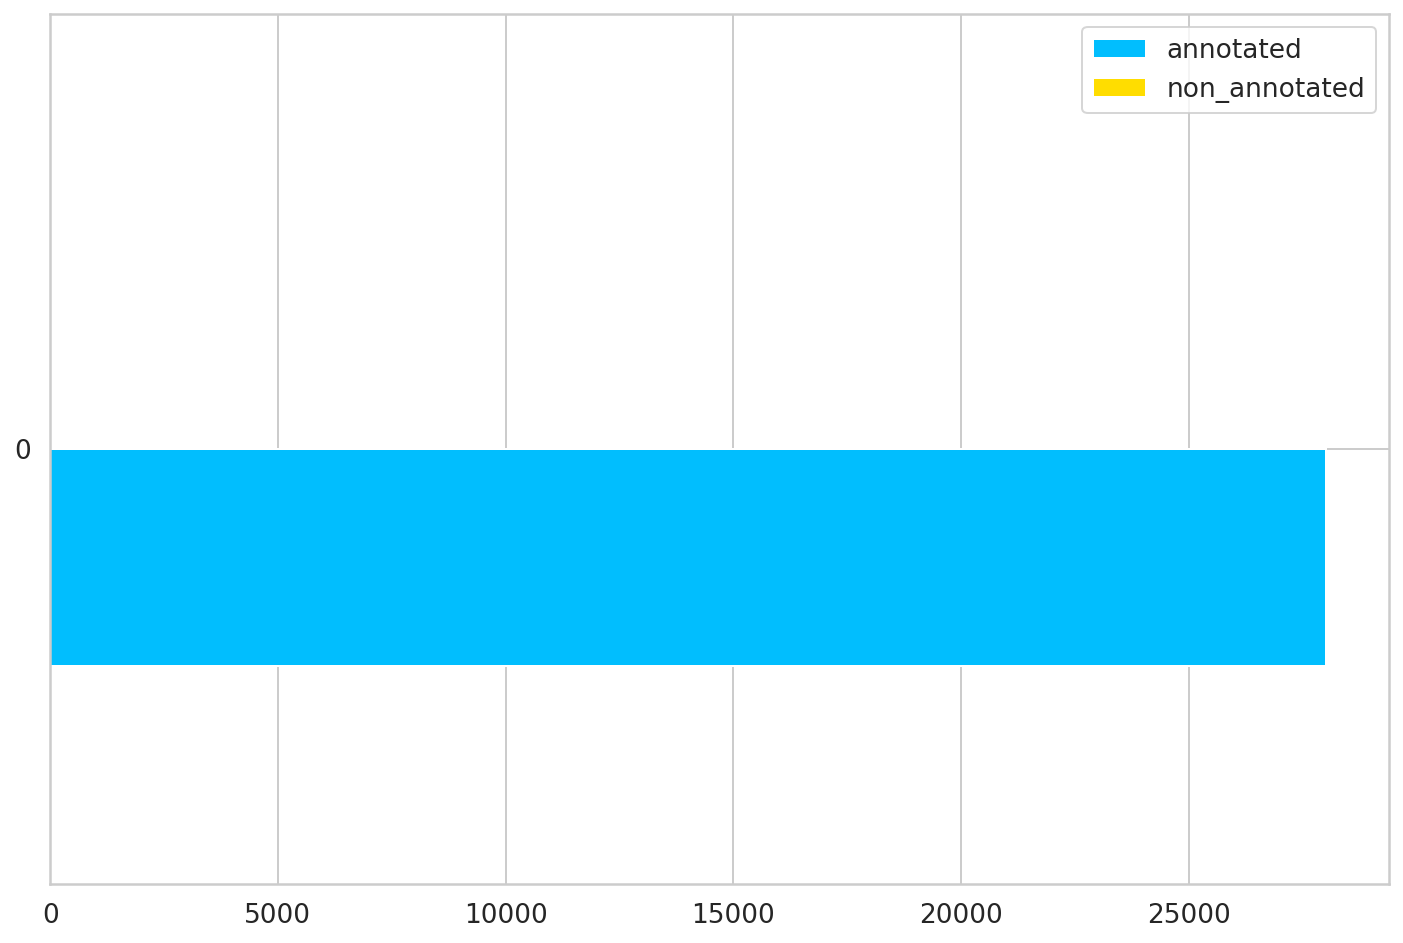

In [14]:
annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
non_annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  annotated=[len(annotated)],
  non_annotated=[len(non_annotated)]
)).plot(kind='barh');

In [15]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [16]:
MAX_TOKEN_COUNT = 512

In [17]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [18]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [19]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [21]:
# load val set
val_df = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/preprocessed_dev.csv")
val_df.shape

(6218, 9)

In [24]:
val_df = val_df.drop(val_df.columns[0], axis=1)
val_df.shape

(6218, 8)

In [25]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
# #PyTorch
# class DiceLoss(nn.Module):

#   def __init__(self, weight=None, size_average=True):
    
#     super(DiceLoss, self).__init__()

#   def forward(self, inputs, targets, smooth=1):
      
#     #comment out if your model contains a sigmoid or equivalent activation layer
#     inputs = F.sigmoid(inputs)       
    
#     #flatten label and prediction tensors
#     inputs = inputs.view(-1)
#     targets = targets.view(-1)
    
#     intersection = (inputs * targets).sum()                            
#     dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
#     return 1 - dice

In [26]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
class_weight

[5.476483516483516,
 1.7882876417396296,
 16.32896461336828,
 2.5215543412264725,
 1.0,
 10.36522462562396,
 1.271196816651362]

In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 5.487450462351387,
 'Diagnosis': 1.7949013394786115,
 'Epidemic Forecasting': 16.35433070866142,
 'Mechanism': 2.5014050582095546,
 'Prevention': 1.0,
 'Transmission': 10.181372549019608,
 'Treatment': 1.2640227203570342}

In [ ]:
# dict(zip(LABEL_COLUMNS, class_weight))
class_weight = torch.tensor(class_weight, device="cuda")

In [27]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    # self.criterion = nn.BCELoss(weight=class_weight)
    # self.criterion = DiceLoss()

    # using weighted loss
    # self.criterion = WeightedMultilabel(class_weight)

    # pos_weight = torch.ones([7])
    # self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # last_hidden_state (batch_size x sequence_length x hidden_size)
    encoded_output = bert_outputs.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(encoded_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))
    # output = self.classifier(output.pooler_output)
    # output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

### optimizer scheduler
- dummy model 

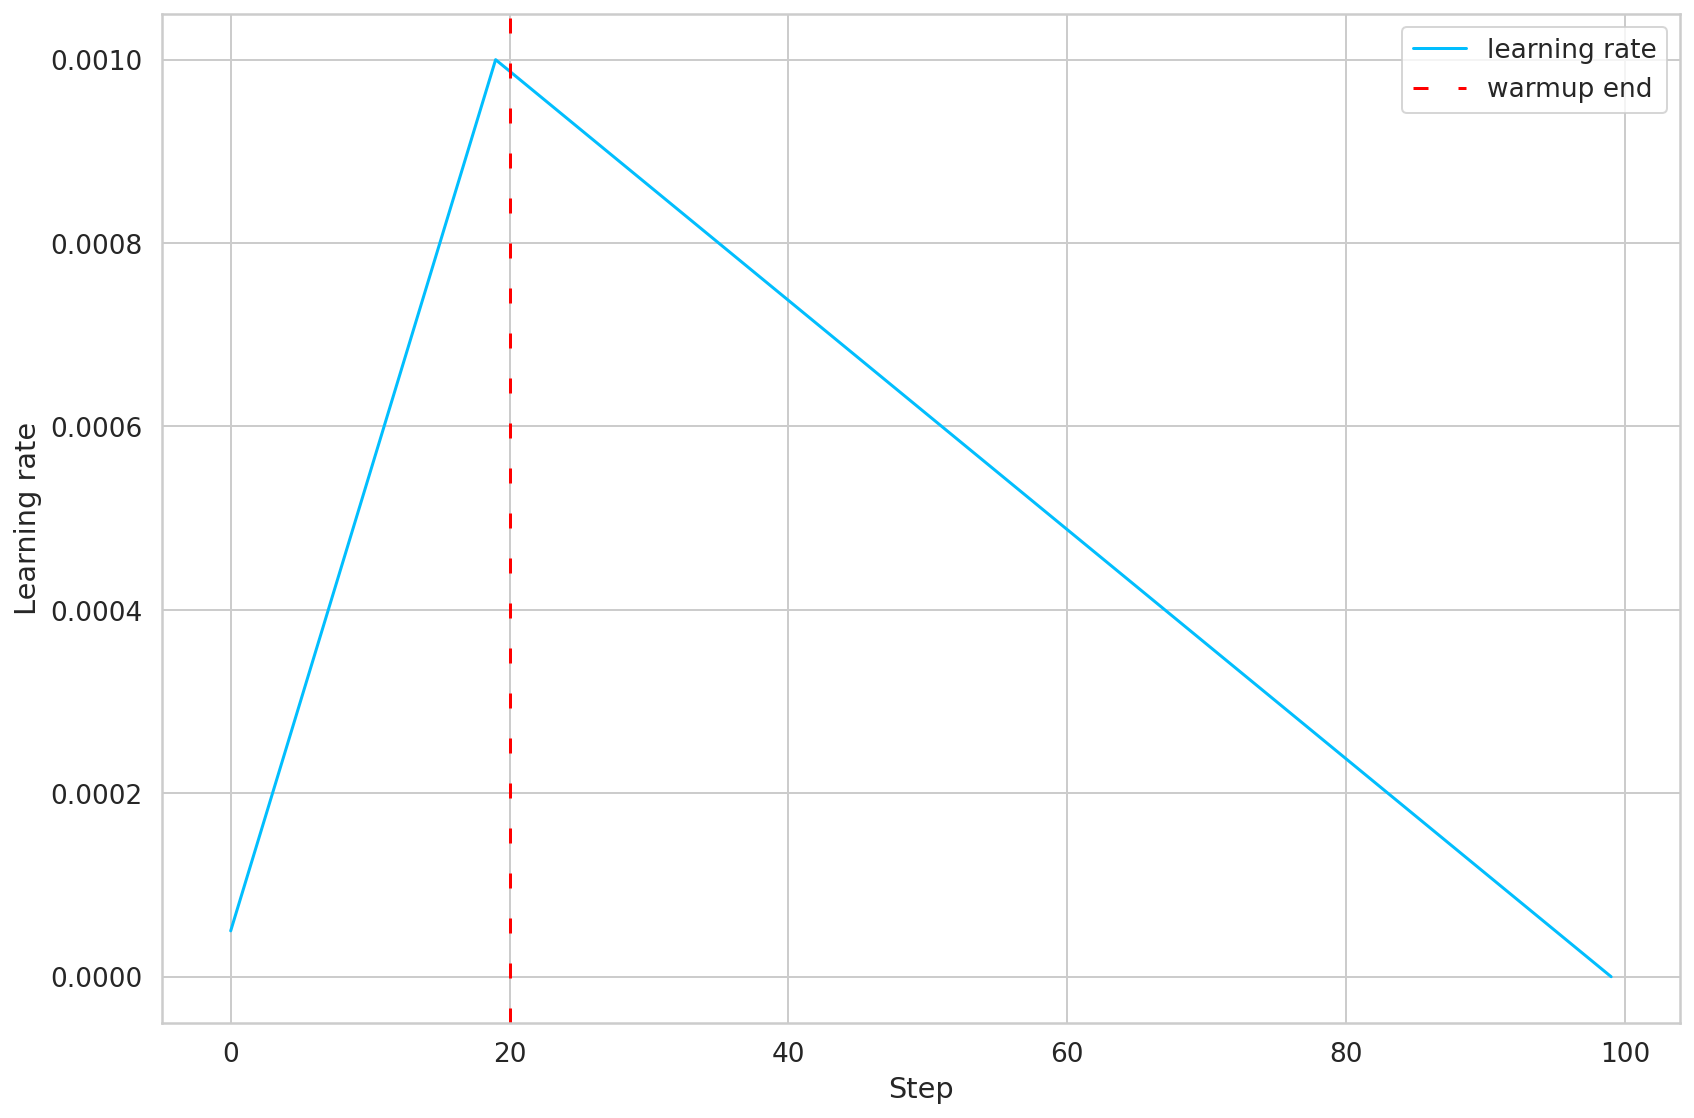

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):

  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

### continuation

In [28]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [29]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3500, 17500)

In [30]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

In [ ]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
# same approach as above can be applied to the model
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5482, 0.5086, 0.3149, 0.3649, 0.4308, 0.5490, 0.4492],
        [0.4947, 0.5273, 0.4164, 0.3910, 0.3953, 0.5708, 0.4941],
        [0.5665, 0.5100, 0.3335, 0.3716, 0.4414, 0.5355, 0.4089],
        [0.5438, 0.5232, 0.3092, 0.3729, 0.4299, 0.5572, 0.4375],
        [0.5496, 0.5269, 0.3175, 0.3602, 0.4343, 0.5449, 0.4427],
        [0.5530, 0.5127, 0.3081, 0.3693, 0.4319, 0.5485, 0.4441],
        [0.5334, 0.5166, 0.3122, 0.3651, 0.4315, 0.5499, 0.4579],
        [0.4838, 0.5611, 0.4841, 0.4175, 0.4116, 0.5799, 0.4936]],
       grad_fn=<SigmoidBackward>)

In [ ]:
criterion(torch.sigmoid(predictions), sample_batch["labels"])

tensor(0.8342, grad_fn=<BinaryCrossEntropyBackward>)

### ROC Curve

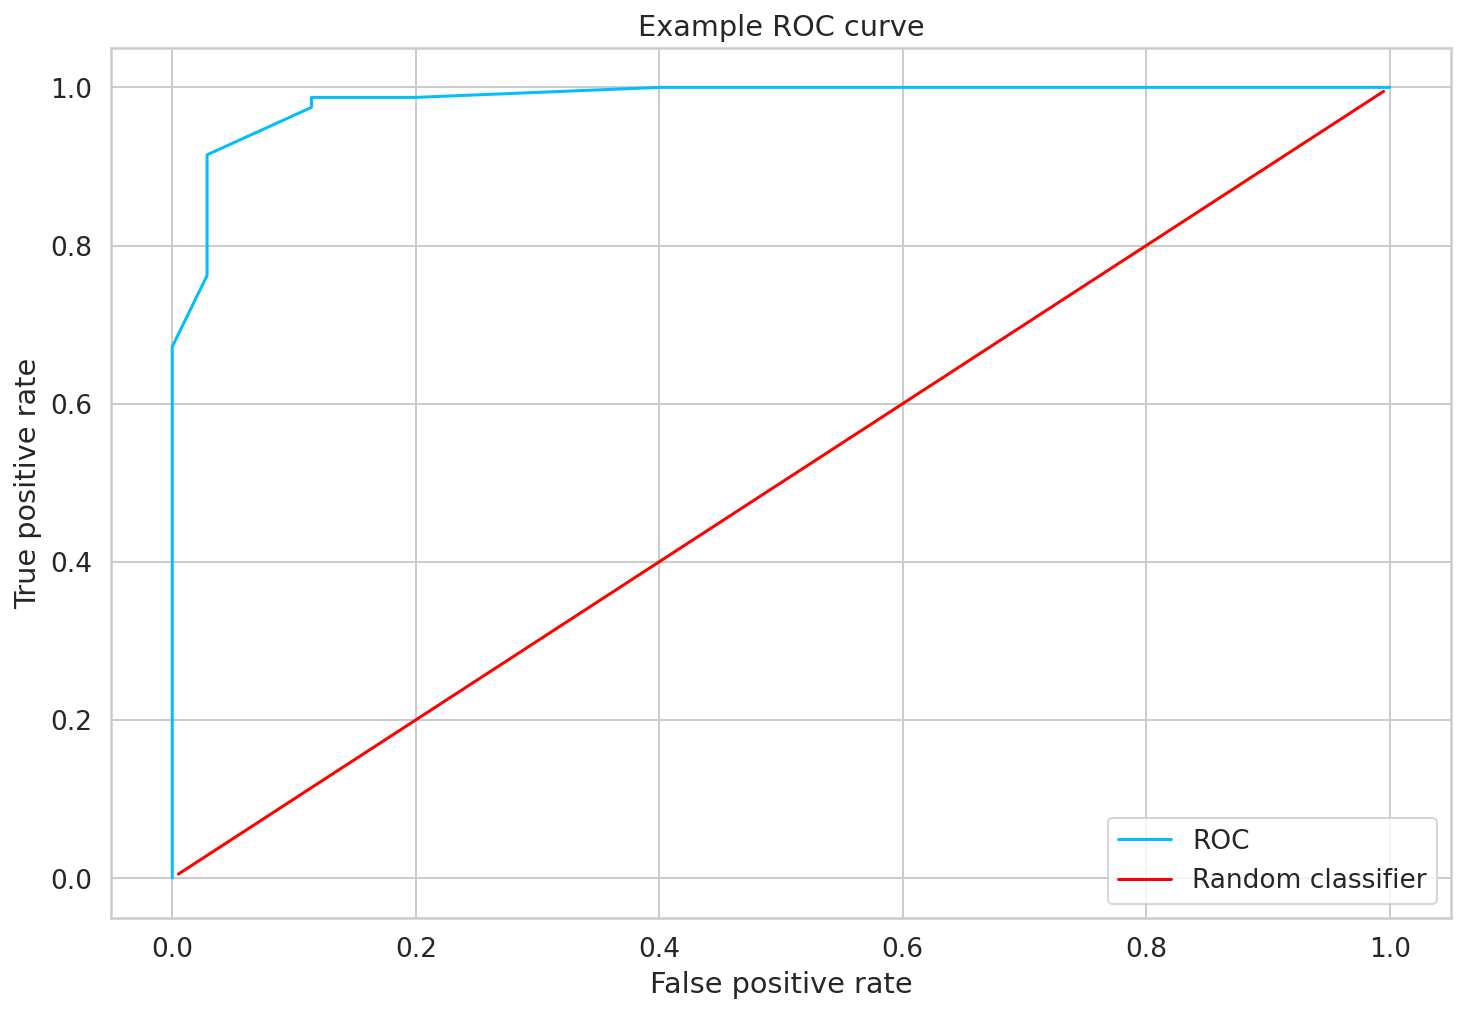

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

### continuation

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative'

/content/drive/MyDrive/Biocreative/Biocreative


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="pubmednlp-lwan-checkpoints",
    filename="pubmednlp-lwan-best-checkpoint-BCEwithlogits",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("pubmednlp-lwan-lightning_logs", name="topic-annotations-BCEwithlogits")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | criterion  | BCEWithLogitsLoss | 0     
2 | fc         | Linear            | 5.4 K 
3 | relu       | ReLU              | 0     
4 | softmax    | Softmax           | 0     
5 | classifier | Linear            | 769   
6 | sigmoid    | Sigmoid           | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.954   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 1754: val_loss reached 0.14241 (best 0.14241), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-BCEwithlogits.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3509: val_loss reached 0.12995 (best 0.12995), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-BCEwithlogits.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 5264: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 7019: val_loss reached 0.12206 (best 0.12206), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-BCEwithlogits.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 8774: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 10529: val_loss was not in top 1


### Test

In [35]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints and logs/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint.ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
trained_model.freeze()

### Evaluation

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [34]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)    
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/6218 [00:00<?, ?it/s]

#### Accuracy

In [36]:
THRESHOLD = 0.9

In [37]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9309)

#### ROC for each tag

In [38]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9878455996513367
Diagnosis: 0.9741138219833374
Epidemic Forecasting: 0.9828183650970459
Mechanism: 0.9846364259719849
Prevention: 0.9879986047744751
Transmission: 0.9669678211212158
Treatment: 0.9736242890357971


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


#### classification report for each class

In [56]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report       0.83      0.89      0.86       481
           Diagnosis       0.90      0.83      0.86      1543
Epidemic Forecasting       0.88      0.37      0.52       192
           Mechanism       0.90      0.85      0.87      1071
          Prevention       0.93      0.95      0.94      2735
        Transmission       0.71      0.33      0.45       256
           Treatment       0.93      0.83      0.88      2204

           micro avg       0.91      0.85      0.88      8482
           macro avg       0.87      0.72      0.77      8482
        weighted avg       0.91      0.85      0.87      8482
         samples avg       0.91      0.88      0.89      8482

